# Обучение и использование многослойного перцептрона для тематический классификации на n > 2 классов 

Мы будем использовать многослойный перцептрон в реализации keras для тематической классификации Reuters на 46 классов. 

Используем keras на каждом этапе классификации: от интерфейса коллекции и обработки текстов до оценок качества.

Из документации keras: 
Dataset of 11,228 newswires from Reuters, labeled over 46 topics. For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

In [1]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


Параметры обучения:
* max_words – количество частотных слов, задающих признаки
* batch_size – размеры выборок из обучающего множества для алгоритма обучения
* nb_epoch – число эпох для обучения 

In [18]:
max_words = 1000
batch_size = 32
nb_epoch = 50

Тренировочное множество : обучающее множество = 4 : 1

In [19]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(nb_words=max_words, test_split=0.2)
print 
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('First doc:',X_train[0])

8982 train sequences
2246 test sequences
First doc: [1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


Число классов

In [20]:
nb_classes = np.max(y_train) + 1
print(nb_classes, 'classes')

46 classes


Задаем векторное пространство с бинарными весами для обучающего множества

In [21]:
tokenizer = Tokenizer(nb_words=max_words)
X_train = tokenizer.sequences_to_matrix(X_train, mode='binary')
X_test = tokenizer.sequences_to_matrix(X_test, mode='binary')
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (8982, 1000)
X_test shape: (2246, 1000)


Задаем векторное пространство с бинарными весами для тестового множества

In [22]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
print('Y_train shape:', Y_train.shape)
print('Y_test shape:', Y_test.shape)

Y_train shape: (8982, 46)
Y_test shape: (2246, 46)


Задаем модель многослойного перцептрона:
* на первом слое 512 узлов с выпрямленной линейной функцией активации ReLU: $\sigma(x) = \max(x, 0)$
* в качестве регуляризации используем dropout: каждый узел с предыдущего уровня будет участвовать в обучении с вероятность $p=0.5$, с вероятностью $1-p=0.5$ будет выброшен. При применении сети узлы не будут выброшены, но выход каждой сети будет домножен на $1-p$.
* на втором слое функция активации softmax: $s(x_i) = \frac{e^{x_i}}{\sum_j e^{x_j}}$

In [23]:
model = Sequential()
model.add(Dense(128, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

* функция потерь: $\texttt{categorical crossentropy}  = - \frac{1}{N} \sum_{i}^{N} \sum_{j}^{M} y_{ij} \log{p_{ij}}$, где $N$ – число объектов в обучающем множестве, $M$ – число классов, $y_{ij}$ – индикаторная переменная (относится ли объект $i$ к классу $j$)
* алгоритм оптимизации: adam (https://arxiv.org/abs/1412.6980v8)
* качество модели: аккуртаность, в обучении мера не участвует 

In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

* 0.1 обучающего множества используем в качестве отладочного множества 
* loss и acc – потери и аккуратность на обучающем множестве
* val_loss и val_acc – потери и  аккуратность на отладочном множестве


In [25]:
history = model.fit(X_train, Y_train,
                    nb_epoch=nb_epoch, batch_size=batch_size,
                    verbose=1, validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/50
8083/8083 [==============================] - 1s - loss: 1.5130 - acc: 0.6642 - val_loss: 1.1598 - val_acc: 0.7486

Оценка качества модели - 1 вариант

In [13]:
score = model.evaluate(X_test, Y_test,
                       batch_size=batch_size, verbose=1)

2112/2246 [===========================>..] - ETA: 0s

In [14]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.884475731149
Test accuracy: 0.786731967943


Оценка качества модели - 2 вариант

In [15]:
out = model.predict(X_test) #model.predict_classes
out1 = model.predict_classes(X_test)
print() 
print(out1)

2246/2246 [==============================] - 0s     

[ 3 10  1 ...,  3  4  1]


In [16]:
from sklearn.metrics import *
print(classification_report(y_test, out1))

             precision    recall  f1-score   support

          0       0.73      0.67      0.70        12
          1       0.66      0.81      0.73       105
          2       0.62      0.65      0.63        20
          3       0.89      0.95      0.92       813
          4       0.83      0.86      0.85       474
          5       1.00      0.20      0.33         5
          6       0.80      0.86      0.83        14
          7       0.50      0.33      0.40         3
          8       0.69      0.71      0.70        38
          9       0.80      0.80      0.80        25
         10       0.90      0.93      0.92        30
         11       0.62      0.72      0.67        83
         12       0.62      0.38      0.48        13
         13       0.44      0.70      0.54        37
         14       0.00      0.00      0.00         2
         15       0.50      0.22      0.31         9
         16       0.73      0.71      0.72        99
         17       0.71      0.42      0.53   

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


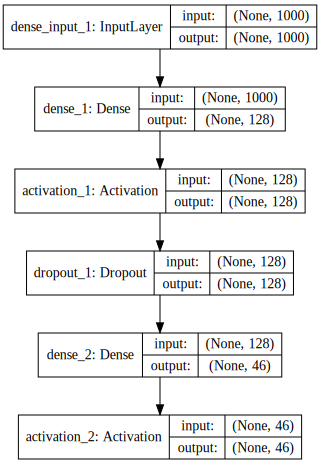

In [17]:
%matplotlib inline
from IPython.display import SVG
from matplotlib import pyplot as plt
from keras.utils.visualize_util import model_to_dot, plot
plt.style.use("ggplot")
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))